In [22]:
import sys
sys.path.append('../Phase_2')            # adjust path to Phase_2
from Phase_2 import Phase2Pipeline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

#########################################
# PHASE 4: Risk Score & Decision Logic
#########################################

## --- Load Classifier and Regressors ---
classifier = joblib.load('../Phase_2/stage_classifier_pipeline.pkl')
rf_model = joblib.load('../Phase_3/random_forest_model.pkl')
ridge_model = joblib.load('../Phase_3/ridge_model.pkl')
svr_model = joblib.load('../Phase_3/svr_model.pkl')

## --- 2. Load Test Data ---
X_test = pd.read_csv('../Phase_3/X_test.csv')
y_test = pd.read_csv('../Phase_3/y_test.csv')


In [23]:
## --- Select Features ---
classifier_features = [
    'Sensor 2', 'Sensor 3', 'Sensor 4', 'Sensor 7', 'Sensor 9', 'Sensor 11',
    'Sensor 12', 'Sensor 14', 'Sensor 15', 'Sensor 17', 'Sensor 20', 'Sensor 21'
]
X_test_classifier = X_test[classifier_features]
X_test_regressors = X_test


In [24]:
def softmax(z):
    return np.exp(z)/np.sum(np.exp(z))

In [25]:
##########################################################
# STEP 1: Extract Stage Probabilities (ensure predict_proba)
##########################################################
stage_probs = classifier.predict_proba(X_test_classifier)
stage_4_probs = stage_probs[:, 3]  # adjust index if necessary
stage_4_probs = softmax(stage_4_probs)

In [26]:
##########################################################
# STEP 2: Predict Time to Failure
#  (Optionally sum models, or pick best performing)
##########################################################
rf_preds = rf_model.predict(X_test_regressors)
svr_preds = svr_model.predict(X_test_regressors)

# Option: average predictions
avg_time_left = rf_preds

# or optionally just rf_preds or another
# avg_time_left = rf_preds

In [27]:
##########################################################
# STEP 3: Compute Risk Score
# Formula options:
#   A) prob / (time_left + epsilon)
#   B) prob * (max_time - time_left)
##########################################################

epsilon = 1e-6
max_time = 150  # <-- adjust max time based on dataset

# Option A: urgency formula
risk_score_urgency = stage_4_probs / (avg_time_left + epsilon)

# Option B: inverse time left
risk_score_inverse = stage_4_probs * (max_time - avg_time_left)

# [SELECT FORMULA]
risk_score = risk_score_inverse  # or risk_score_urgency

In [28]:
##########################################################
# STEP 4: Normalize Risk Score
##########################################################
def min_max_normalize(arr):
    return (arr - np.min(arr)) / (np.max(arr) - np.min(arr) + 1e-6)

normalized_risk_score = min_max_normalize(risk_score)


In [29]:
##########################################################
# STEP 5: Threshold (initial fixed, later dynamic tuning)
##########################################################
fixed_threshold = 0.7
dynamic_threshold = np.percentile(normalized_risk_score, 90)

# optionally use Youden’s J or PR-tuning
alerts = normalized_risk_score > fixed_threshold
alerts_dynamic = normalized_risk_score > dynamic_threshold

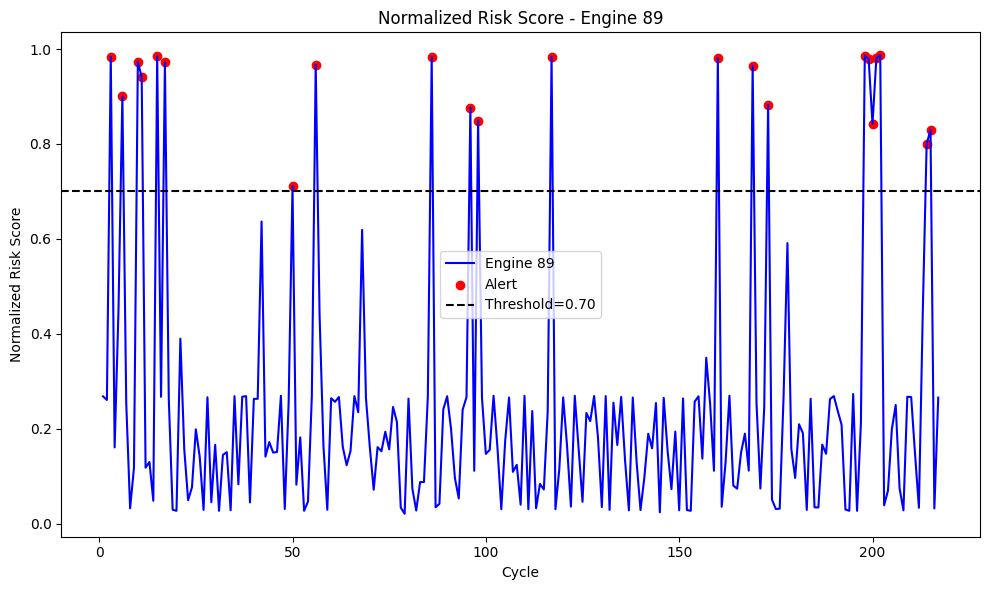

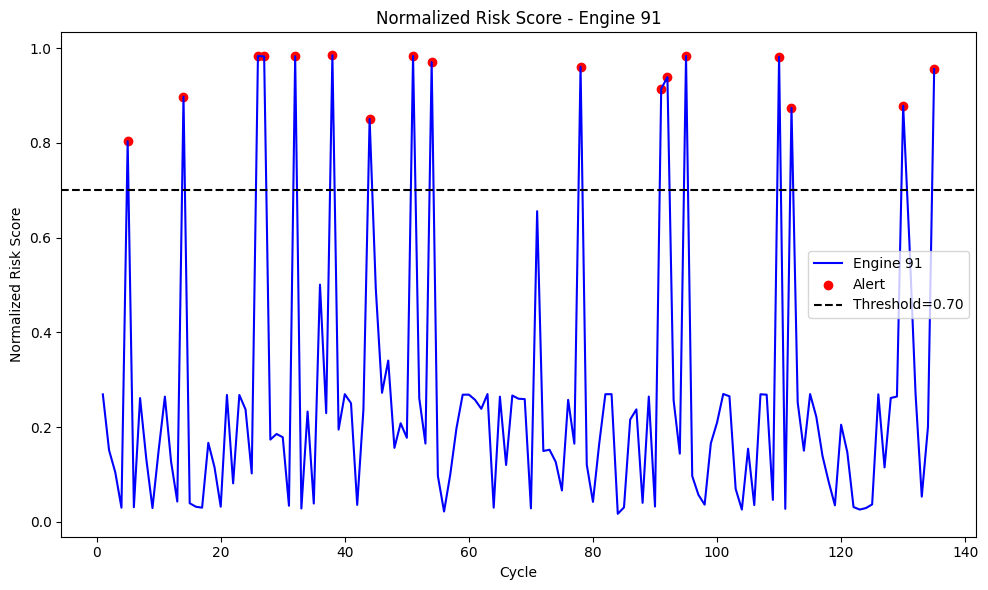

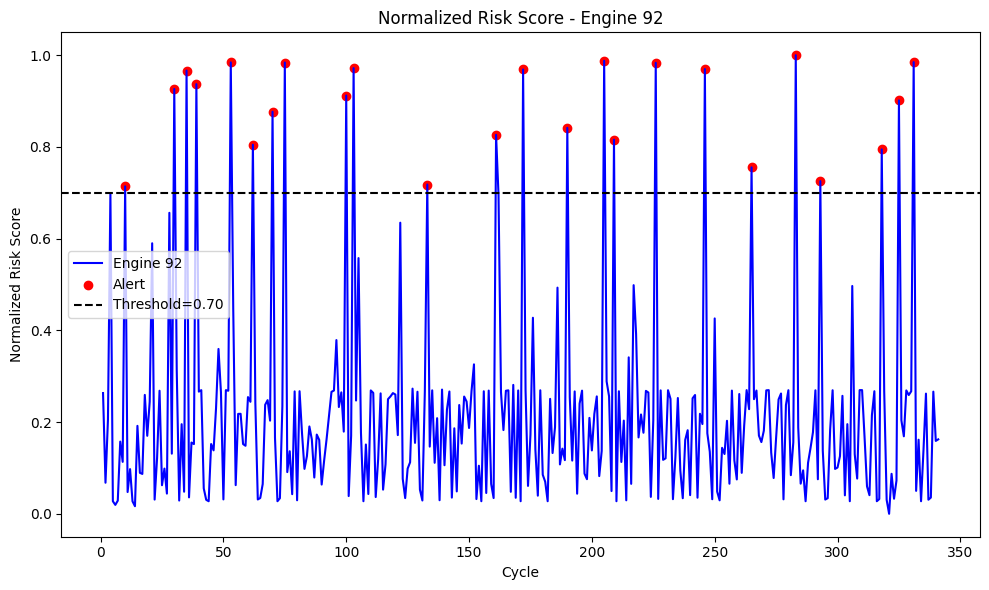

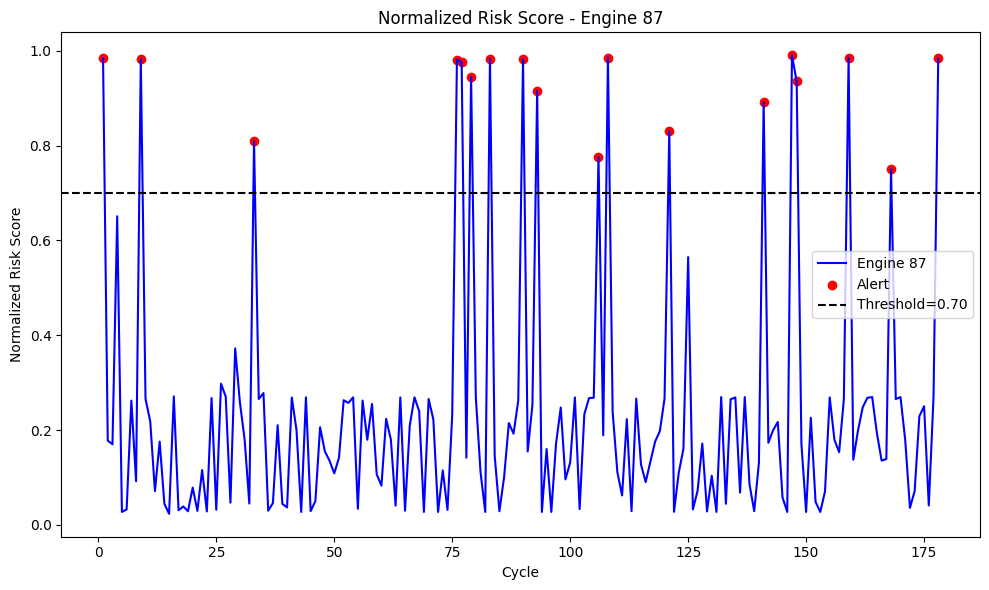

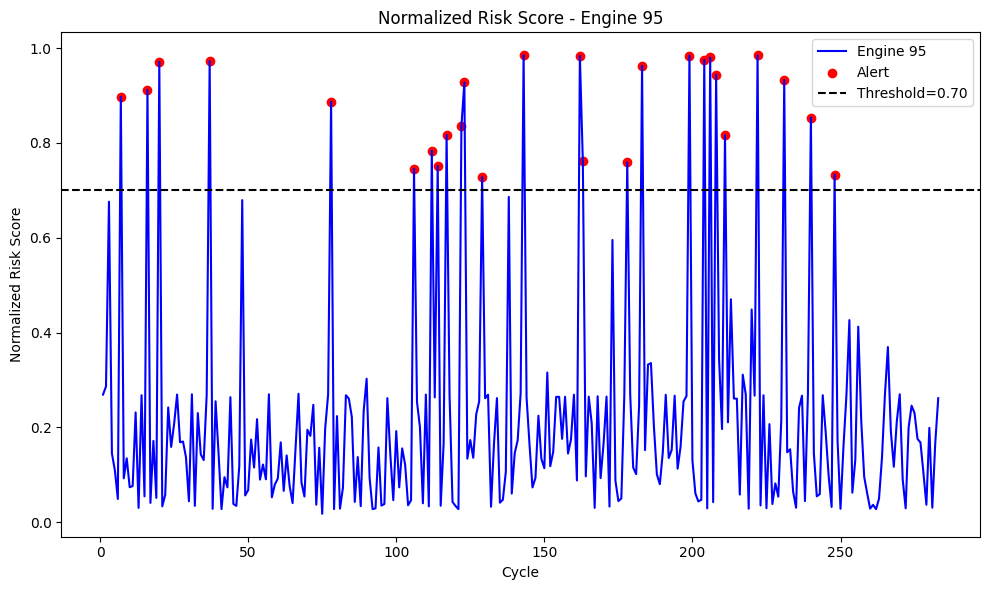

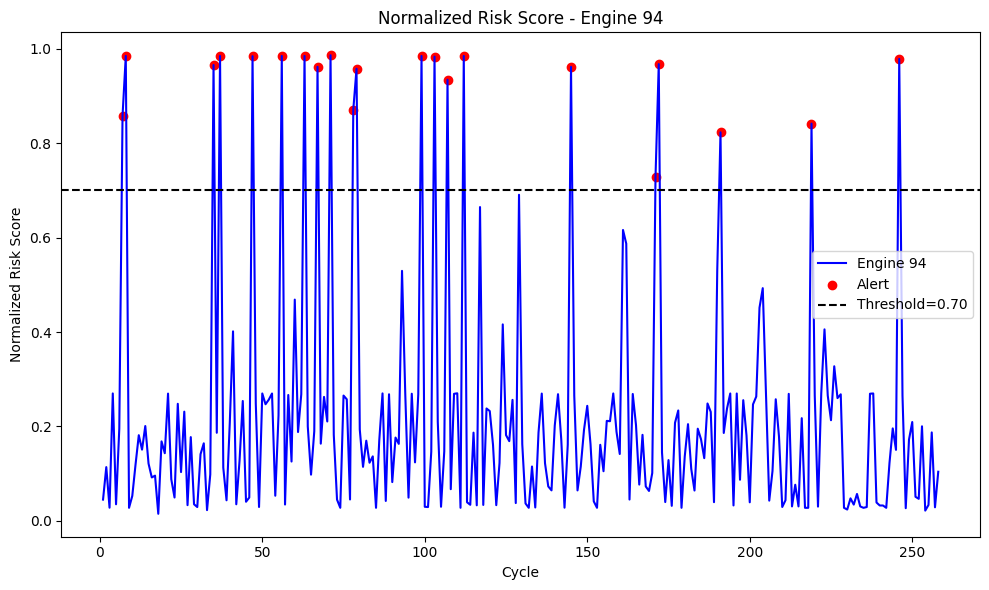

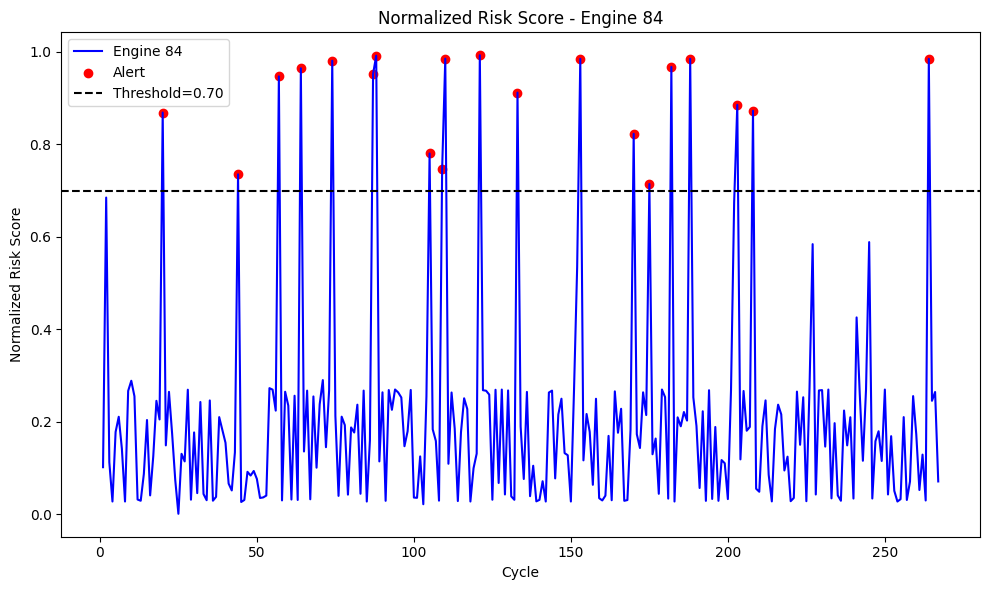

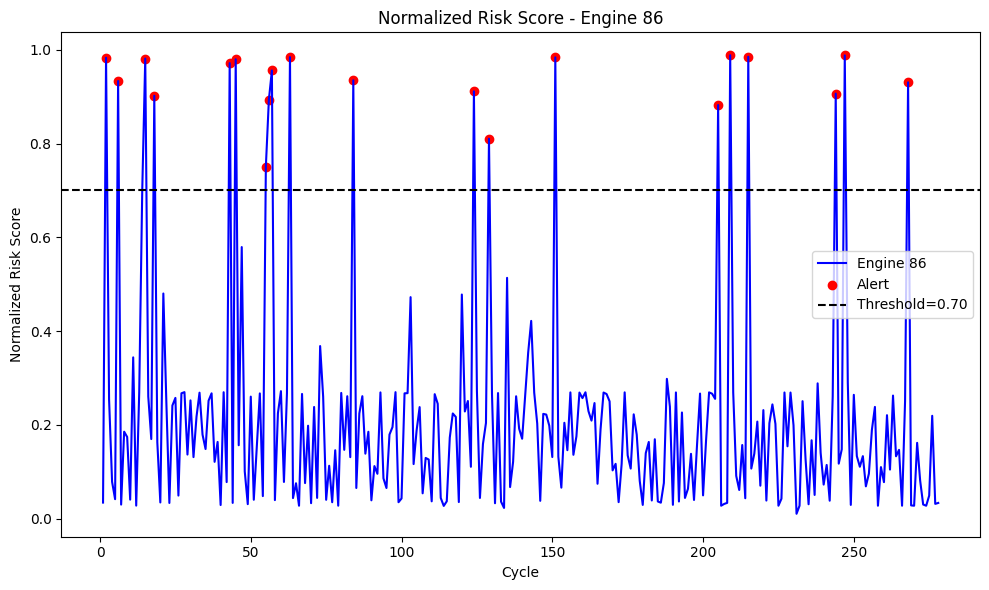

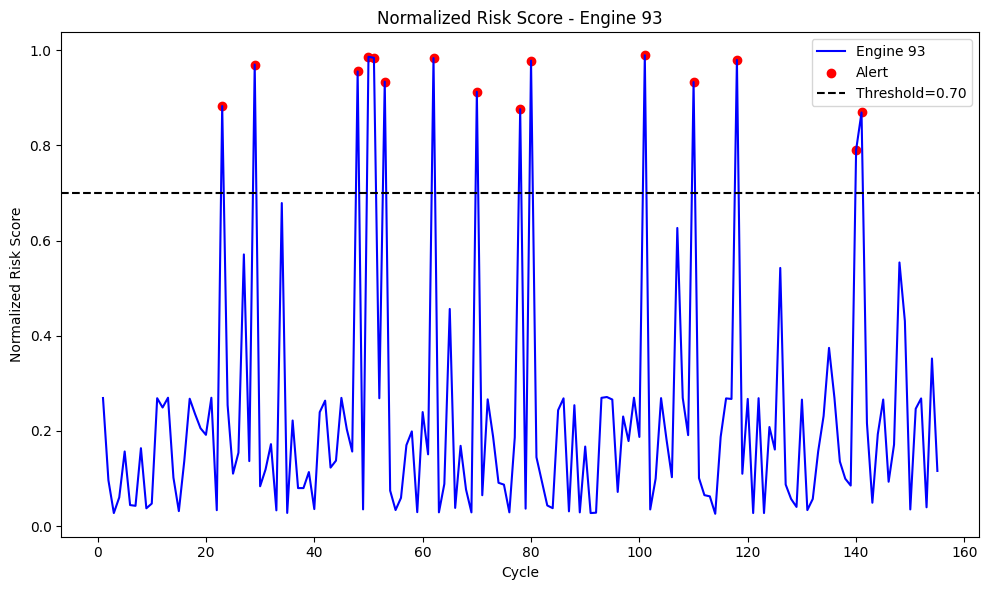

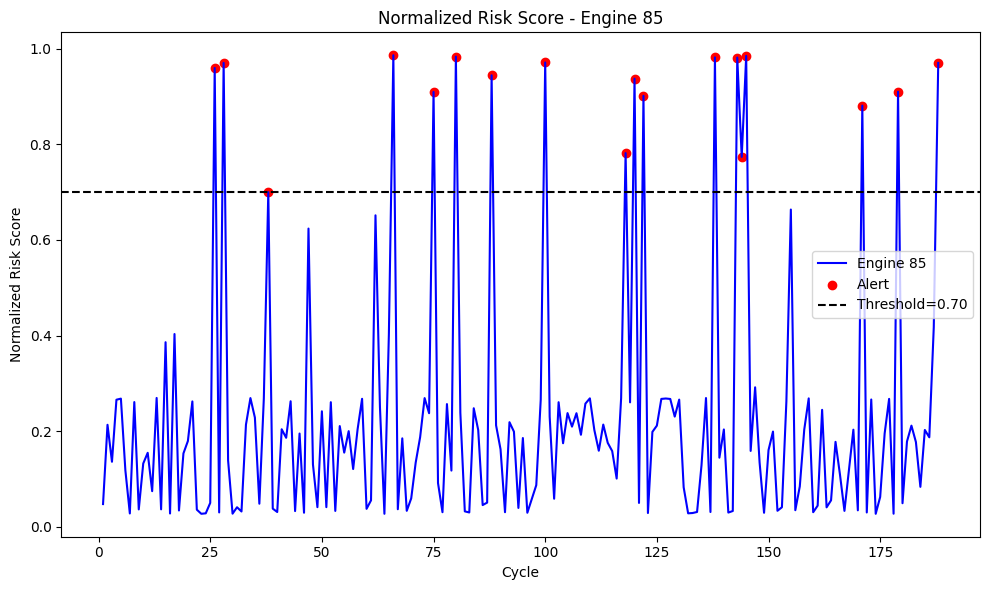

In [30]:
##########################################################
# STEP 6: Visualization over time for selected engines
##########################################################
df_full = pd.read_csv('../Phase_1/train_FD001_phase_1.csv')
df_full.rename(columns={'Num cycles': 'cycle'}, inplace=True)

# align predictions to last N cycles
df_tail = df_full.tail(len(X_test)).copy()

df_tail['Stage_4_Prob'] = stage_4_probs
df_tail['Avg_Time_Left'] = avg_time_left
df_tail['Risk_Score'] = risk_score
df_tail['Normalized_Risk_Score'] = normalized_risk_score
df_tail['Alert'] = alerts
df_tail['Alert_Dynamic'] = alerts_dynamic

import random
import matplotlib.pyplot as plt

# Get all unique engine IDs
all_engines = df_tail['Engine no'].unique()

# Randomly select 10 engines
selected_engines = random.sample(list(all_engines), 10)

# Plot each engine separately
for i, eng in enumerate(selected_engines):
    eng_data = df_tail[df_tail['Engine no'] == eng]
    
    plt.figure(figsize=(10,6))
    plt.plot(eng_data['cycle'], eng_data['Normalized_Risk_Score'], label=f'Engine {eng}', color='blue')
    
    # Highlight alerts
    over = eng_data[eng_data['Alert']]
    plt.scatter(over['cycle'], over['Normalized_Risk_Score'], color='red', label='Alert')

    # Threshold line
    plt.axhline(fixed_threshold, color='black', linestyle='--', label=f'Threshold={fixed_threshold:.2f}')
    
    plt.xlabel('Cycle')
    plt.ylabel('Normalized Risk Score')
    plt.title(f'Normalized Risk Score - Engine {eng}')
    plt.legend()
    plt.tight_layout()
    plt.show()


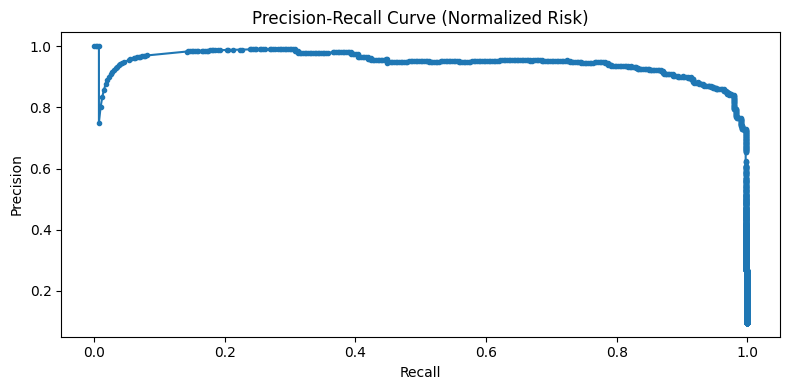

In [31]:
##########################################################
# STEP 7: (optional) Precision-Recall Analysis for threshold tuning
##########################################################
from sklearn.metrics import precision_recall_curve

y_true = (y_test.values.flatten() < 10).astype(int)  # e.g., failure <10 cycles
prec, rec, thresholds = precision_recall_curve(y_true, normalized_risk_score)

plt.figure(figsize=(8,4))
plt.plot(rec, prec, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Normalized Risk)')
plt.tight_layout()
plt.show()


In [32]:
# Get number of alerts at each threshold
num_alerts = [(normalized_risk_score > t).sum() for t in thresholds]

# Combine threshold and count info
count = 0
for t_val, n_alert in zip(thresholds, num_alerts):
    # print(f"Threshold: {t_val:.3f} → Alerts: {n_alert}")
    count = count + 1
print(count)

3639


In [33]:
##########################################################
# STEP 8: (Optional) Unit tests for Risk Score + Normalization
##########################################################
def test_risk_score_formula(prob, time_left, expected, formula):
    computed = formula(prob, time_left)
    assert np.isclose(computed, expected), f"Expected {expected}, got {computed}"

def test_min_max_normalization():
    arr = np.array([0, 5, 10])
    norm = min_max_normalize(arr)
    assert np.isclose(norm[0], 0)
    assert np.isclose(norm[-1], 1)



In [34]:
from sklearn.metrics import precision_recall_curve, f1_score

# Ground truth: Define 'true high risk' (e.g., failure in next <=10 cycles)
y_true = (y_test.values.flatten() <= 10).astype(int)  # binary label: 1 if close to failure

# Precision-Recall curve
precisions, recalls, thresholds = precision_recall_curve(y_true, normalized_risk_score)

# Compute F1-score at each threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

# Find threshold with max F1
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Optimal Threshold based on max F1: {best_threshold:.4f}")
print(f"Precision={precisions[best_idx]:.4f}, Recall={recalls[best_idx]:.4f}, F1={f1_scores[best_idx]:.4f}")

# Apply refined threshold
alerts_refined = normalized_risk_score >= best_threshold

✅ Optimal Threshold based on max F1: 0.5313
Precision=0.8597, Recall=0.9645, F1=0.9091


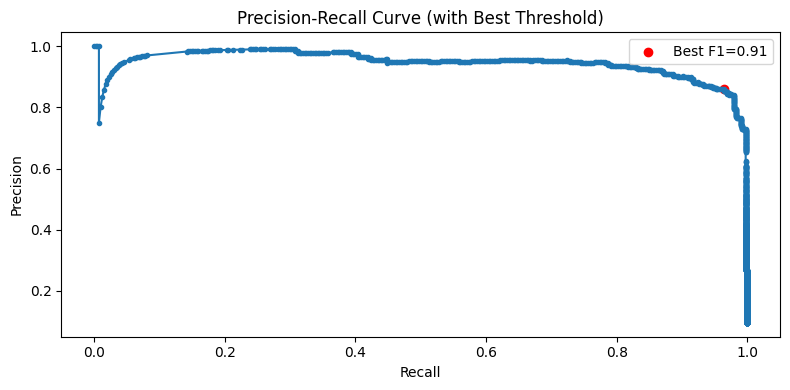

In [35]:
# Plot PR Curve and mark best threshold
plt.figure(figsize=(8,4))
plt.plot(recalls, precisions, marker='.')
plt.scatter(recalls[best_idx], precisions[best_idx], color='red', label=f'Best F1={f1_scores[best_idx]:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision-Recall Curve (with Best Threshold)')
plt.tight_layout()
plt.show()

# Add alerts_refined column
df_tail['Alert_Refined'] = alerts_refined

In [36]:
num_alerts = df_tail['Alert_Refined'].sum()
print(f"Number of samples flagged by refined threshold: {num_alerts}")


Number of samples flagged by refined threshold: 442


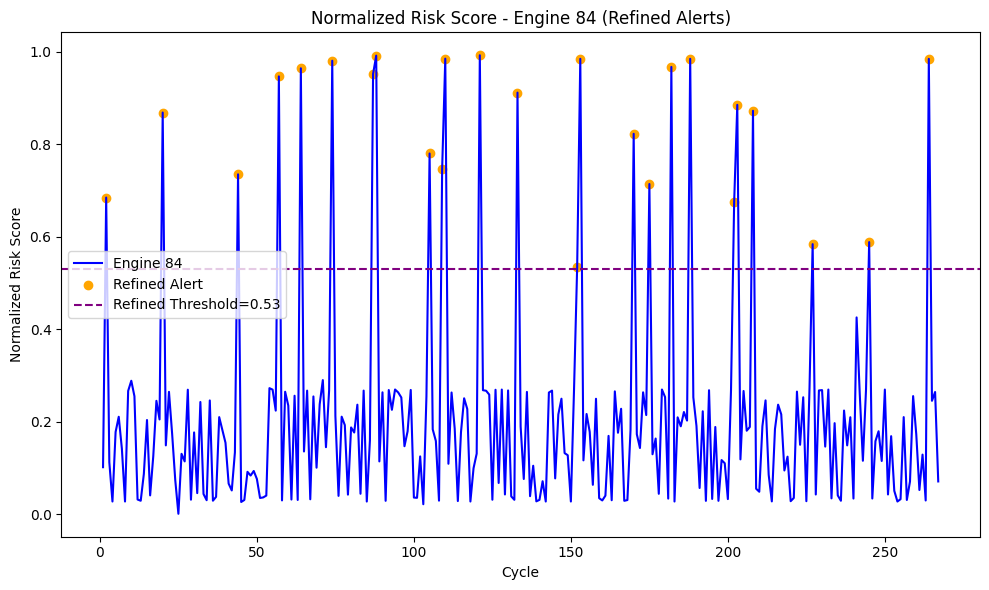

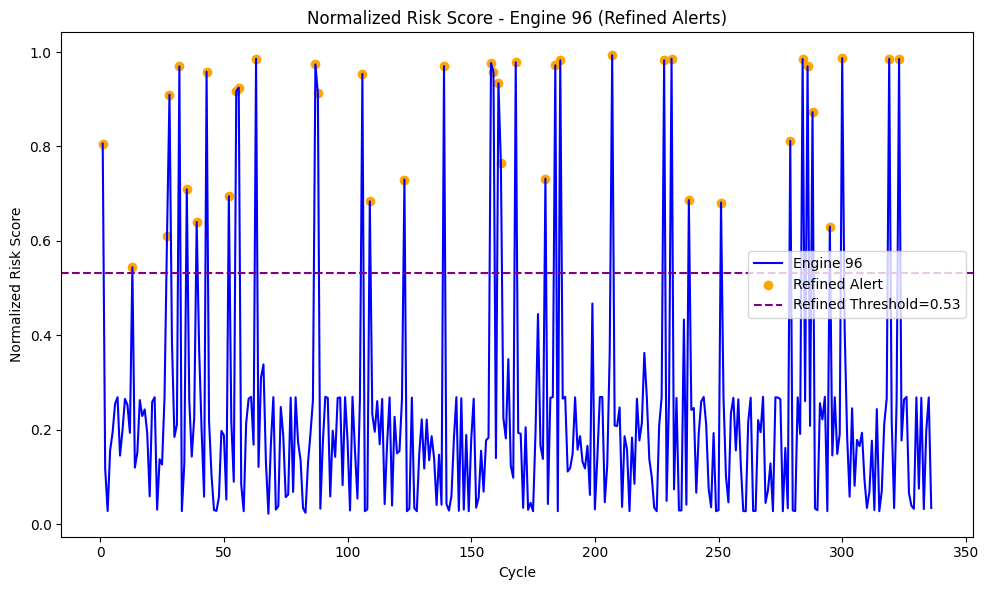

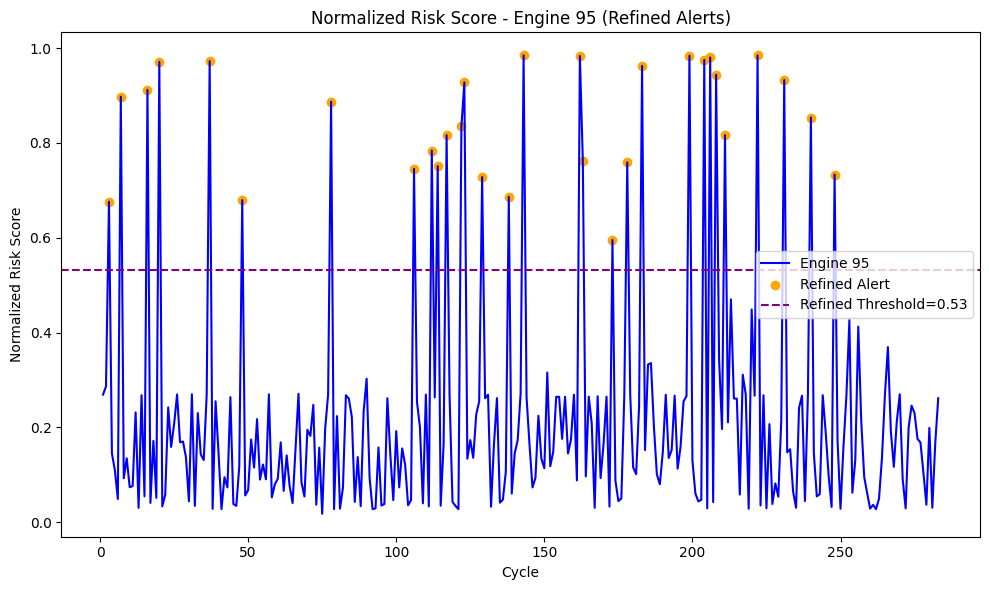

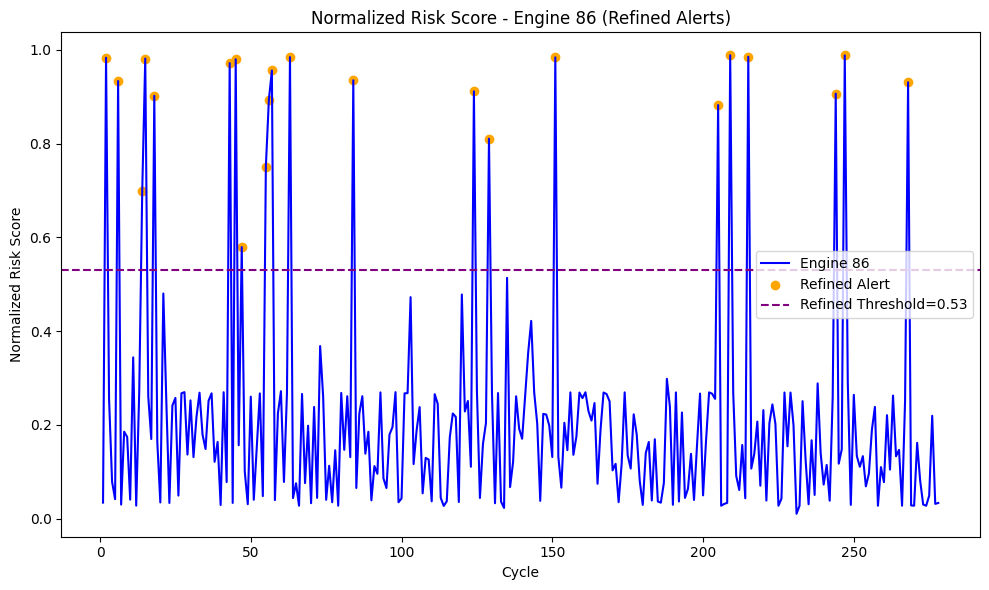

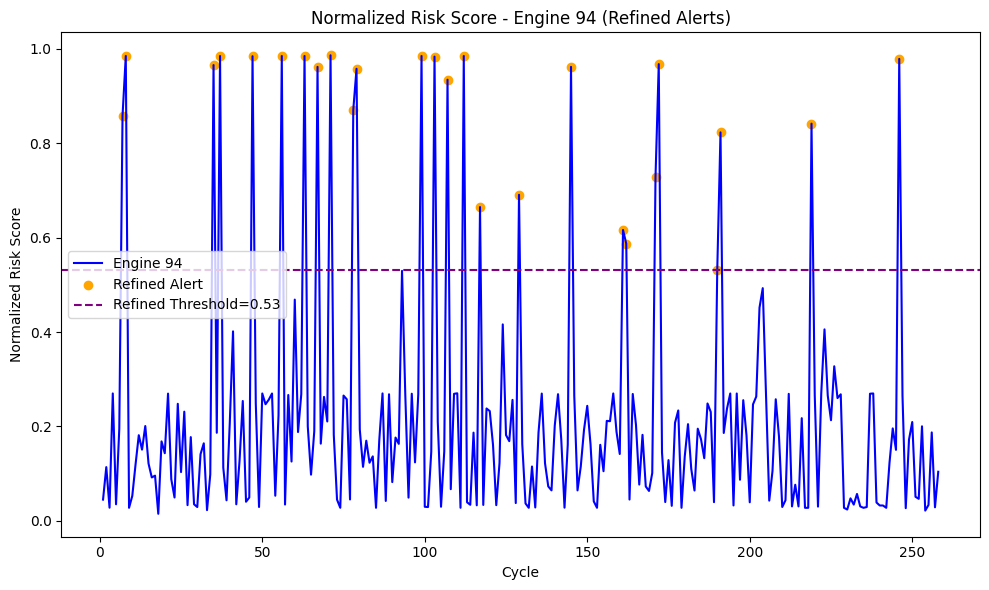

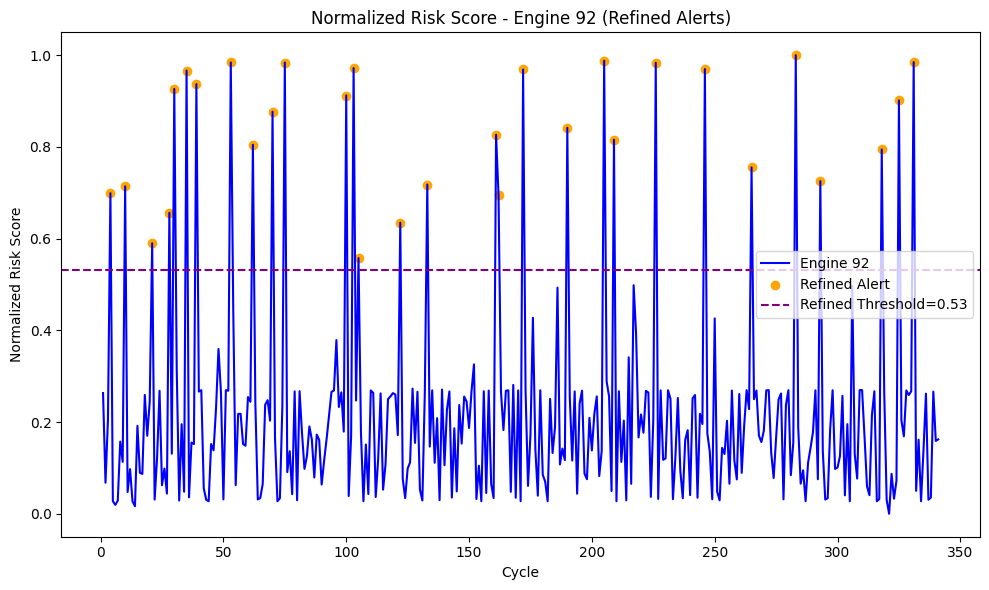

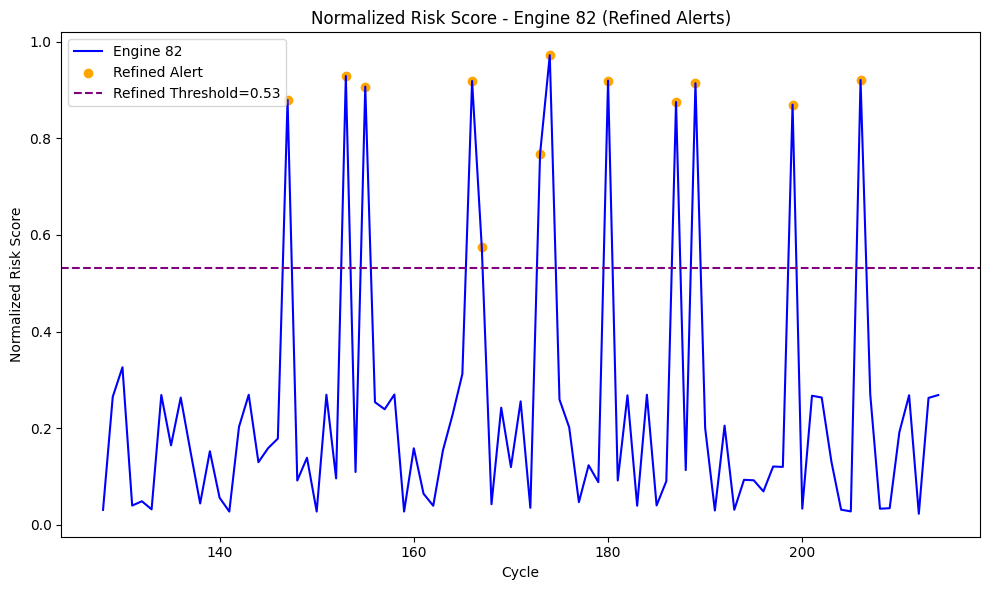

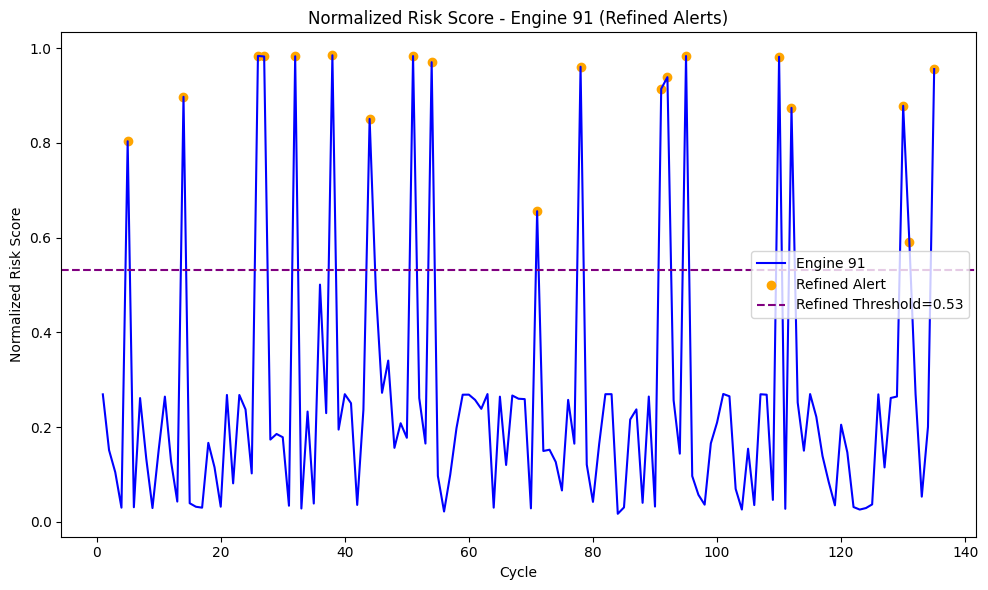

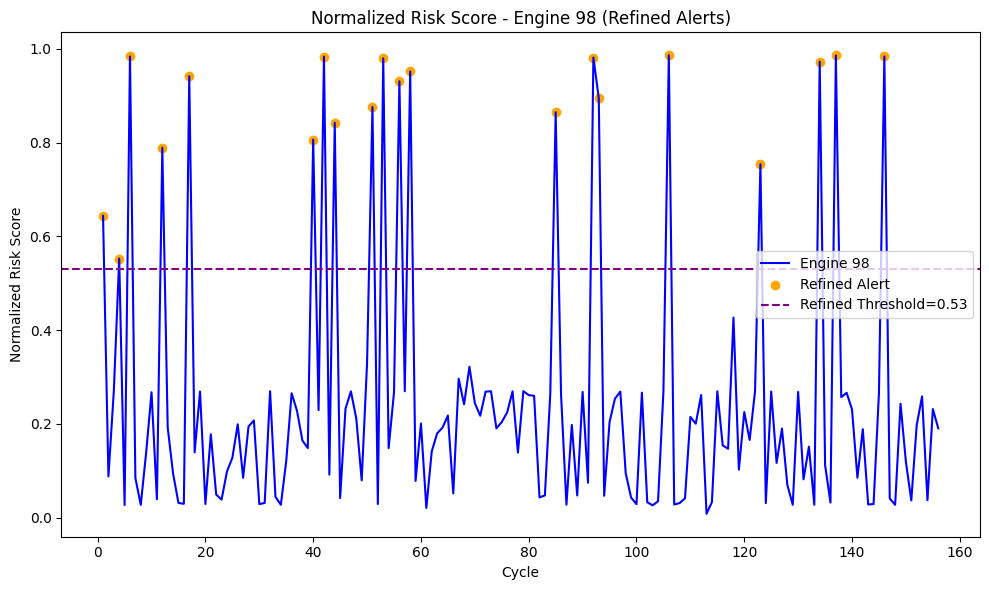

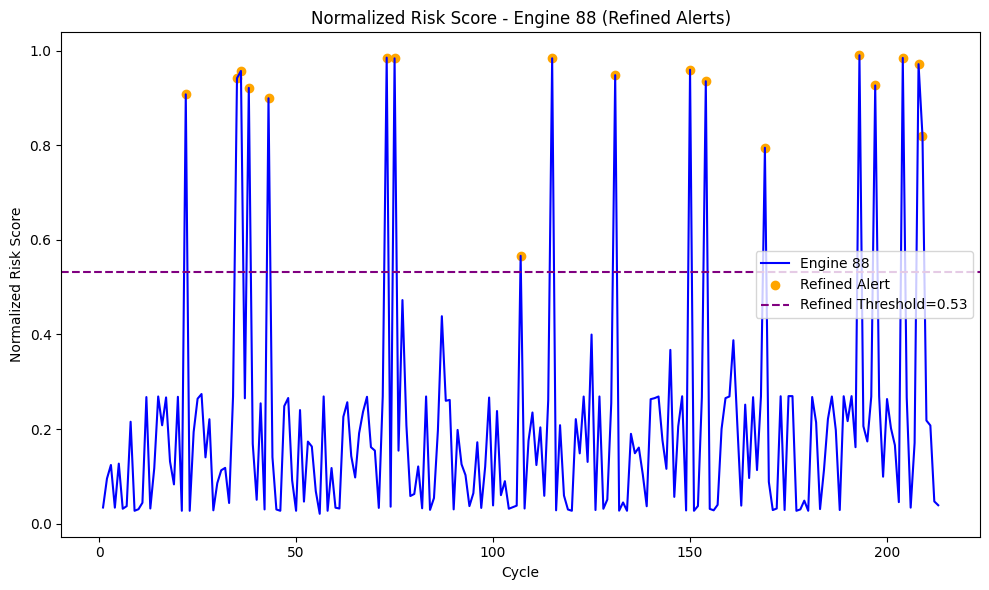

In [37]:
import random
import matplotlib.pyplot as plt

# Add refined alerts column to df_tail
df_tail['Alert_Refined'] = alerts_refined

# Get all unique engine IDs
all_engines = df_tail['Engine no'].unique()

# Randomly select 10 engines
selected_engines = random.sample(list(all_engines), 10)

# Plot each engine separately
for i, eng in enumerate(selected_engines):
    eng_data = df_tail[df_tail['Engine no'] == eng]
    
    plt.figure(figsize=(10,6))
    plt.plot(eng_data['cycle'], eng_data['Normalized_Risk_Score'], label=f'Engine {eng}', color='blue')
    
    # Highlight refined alerts
    over = eng_data[eng_data['Alert_Refined']]
    plt.scatter(over['cycle'], over['Normalized_Risk_Score'], color='orange', label='Refined Alert')

    # Threshold line (refined threshold)
    plt.axhline(best_threshold, color='purple', linestyle='--', label=f'Refined Threshold={best_threshold:.2f}')
    
    plt.xlabel('Cycle')
    plt.ylabel('Normalized Risk Score')
    plt.title(f'Normalized Risk Score - Engine {eng} (Refined Alerts)')
    plt.legend()
    plt.tight_layout()
    plt.show()
